In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
# Load in the train and test datasets
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_lenth'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Donna'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


<Axes: title={'center': 'Pearson Correlation of Features'}>

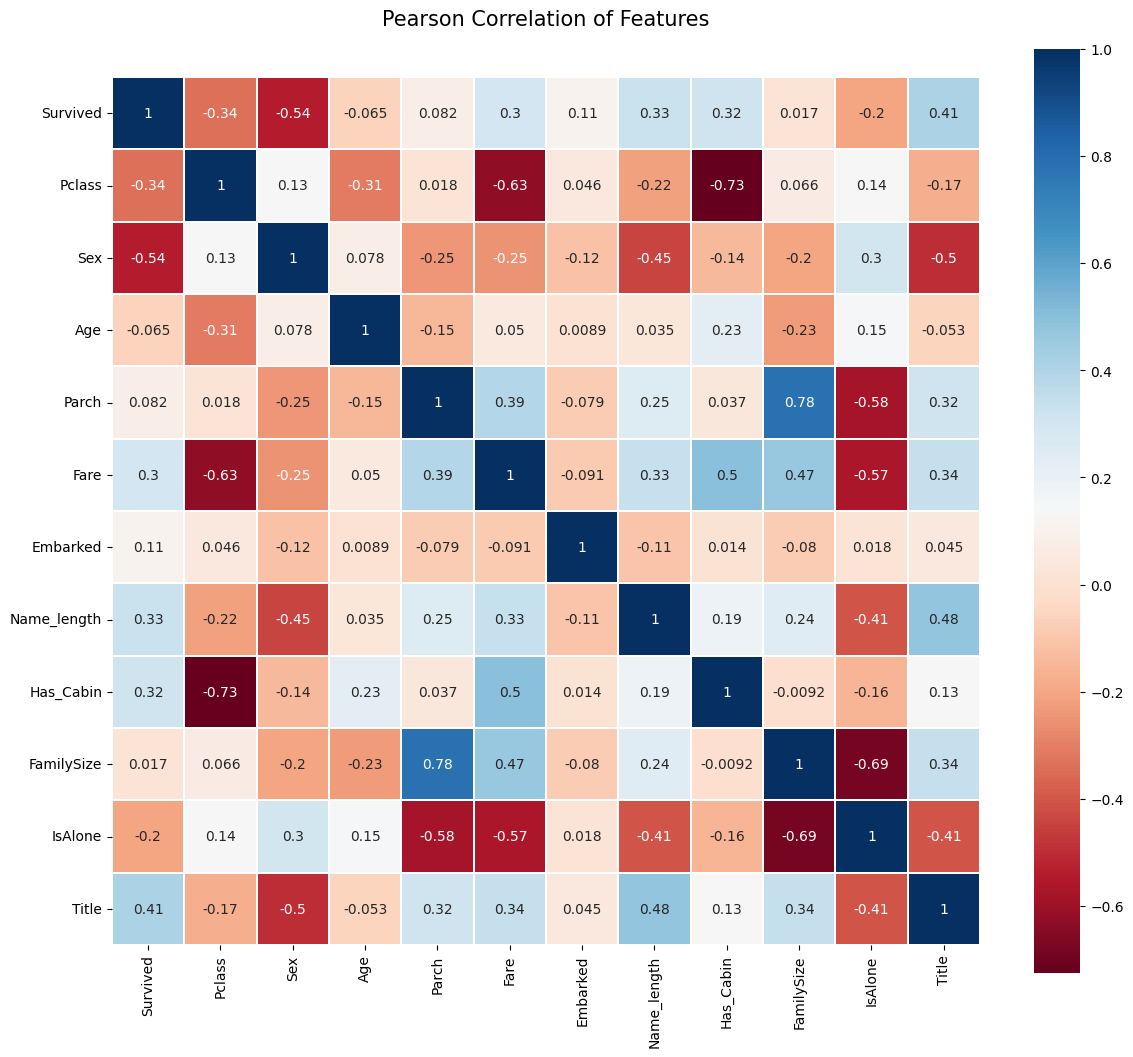

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

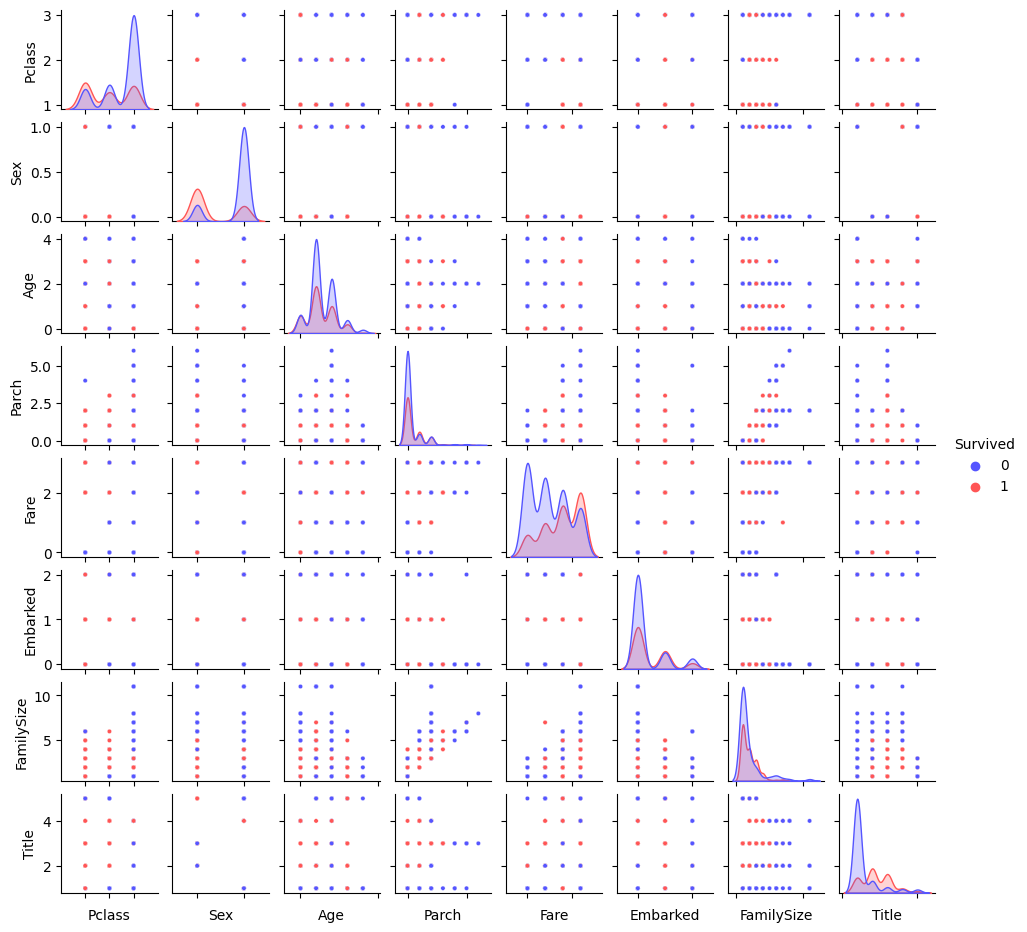

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [8]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 23
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=23, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)

    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_
        

### Out-of-Fold Predictions

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
1. Random Forest Classifier
2. Extra Trees Classifier
3. AdaBoost Classifier
4. Gradient Boosting Classifier
5. Support Vector Machine

### Parameters
**n_jobs**

**n_estimators**

**max_depth**

**verbose**


In [10]:
# Random Forest params
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees params
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost params
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting params
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier params 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [11]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [12]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [13]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers

In [14]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

# 결과 출력
print("Random Forest Feature Importances:", rf_features)
print("Extra Trees Feature Importances:", et_features)
print("AdaBoost Feature Importances:", ada_features)
print("Gradient Boosting Feature Importances:", gb_features)

Random Forest Feature Importances: [0.1096358  0.2088004  0.03830351 0.02348568 0.04391961 0.02889914
 0.1146794  0.05702033 0.06814382 0.01175417 0.29535813]
Extra Trees Feature Importances: [0.12867638 0.37654816 0.03010508 0.01619137 0.05230677 0.02873182
 0.04962057 0.08380291 0.04362148 0.02122588 0.16916958]
AdaBoost Feature Importances: [0.028 0.008 0.014 0.064 0.036 0.01  0.712 0.012 0.044 0.006 0.066]
Gradient Boosting Feature Importances: [0.08563777 0.00976693 0.05471497 0.01090412 0.04945156 0.02935889
 0.17269811 0.04009417 0.10895435 0.0069916  0.43142753]


In [15]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features
                                  })

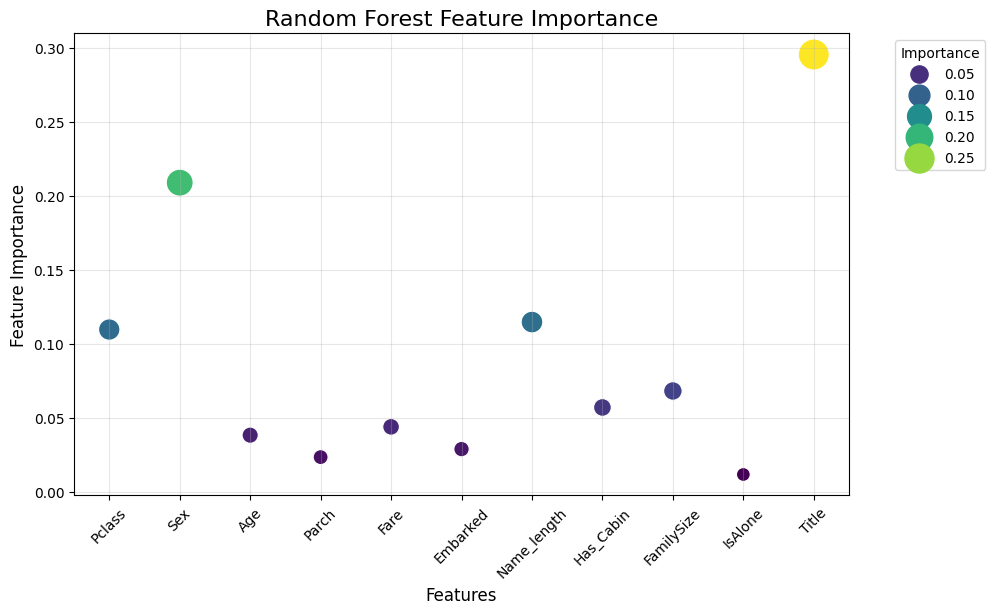

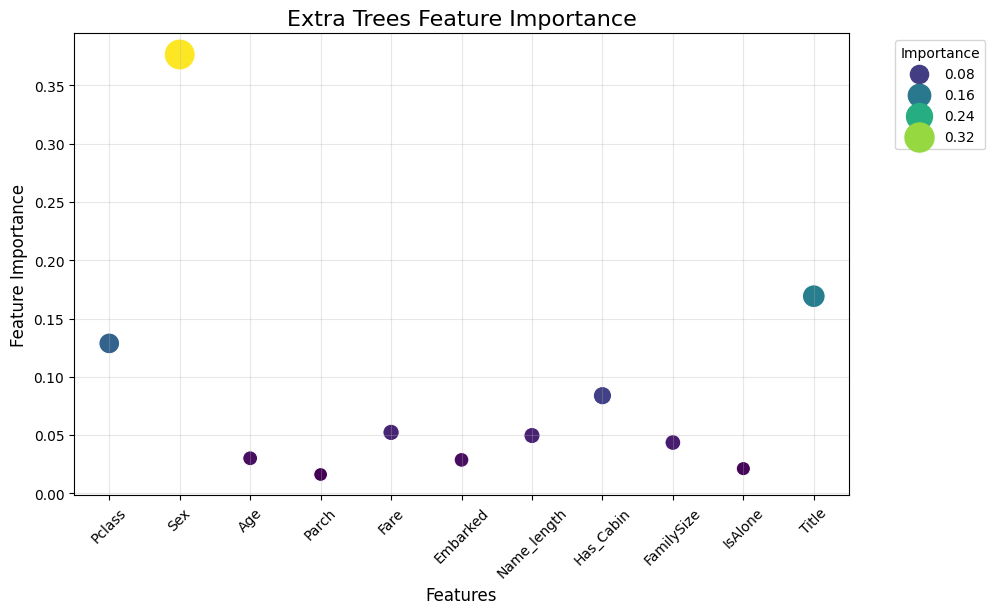

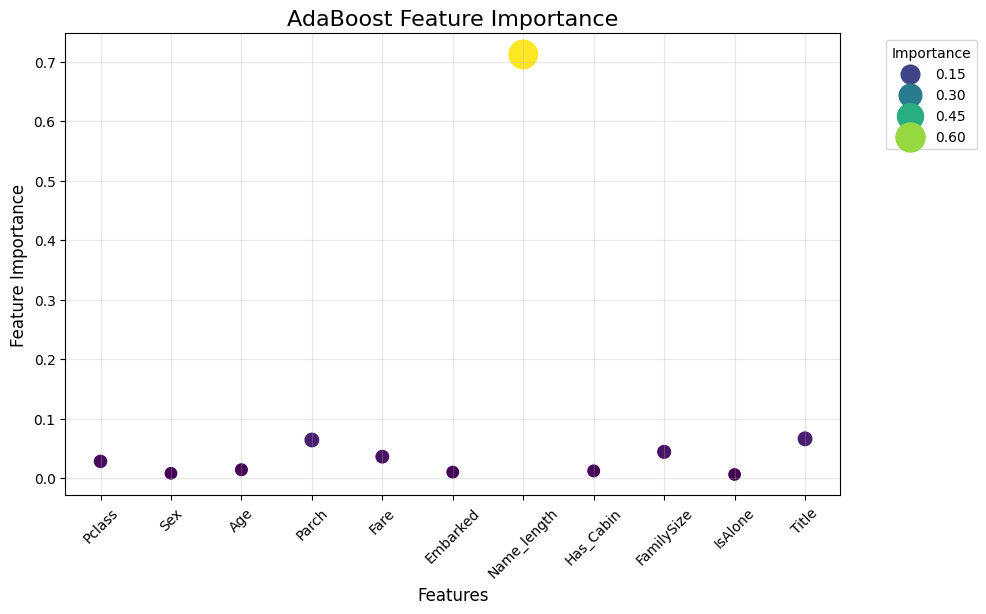

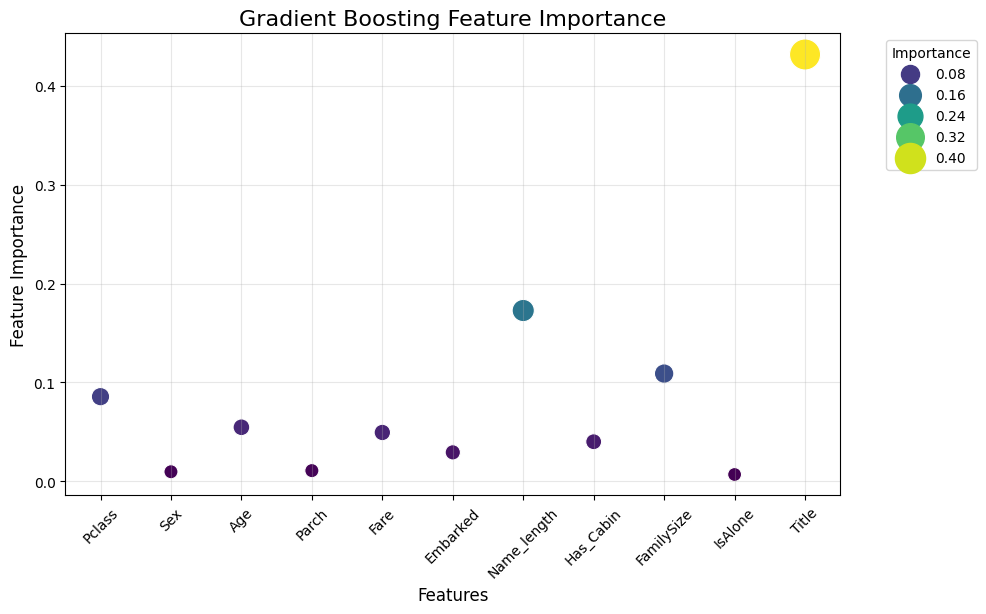

In [16]:
# 시각화 함수
def plot_feature_importance(feature_dataframe, importance_column, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=feature_dataframe['features'],
        y=feature_dataframe[importance_column],
        size=feature_dataframe[importance_column],
        sizes=(100, 500),
        hue=feature_dataframe[importance_column],
        palette='viridis',
        legend="brief"
    )
    plt.title(title, fontsize=16)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Feature Importance', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Importance', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.show()

# Random Forest Feature Importance
plot_feature_importance(feature_dataframe, 'Random Forest feature importances', 'Random Forest Feature Importance')

# Extra Trees Feature Importance
plot_feature_importance(feature_dataframe, 'Extra Trees feature importances', 'Extra Trees Feature Importance')

# AdaBoost Feature Importance
plot_feature_importance(feature_dataframe, 'AdaBoost feature importances', 'AdaBoost Feature Importance')

# Gradient Boosting Feature Importance
plot_feature_importance(feature_dataframe, 'Gradient Boost feature importances', 'Gradient Boosting Feature Importance')


In [17]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1, numeric_only=True)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.109636,0.128676,0.028,0.085638,0.087987
1,Sex,0.208800,0.376548,0.008,0.009767,0.150779
2,Age,0.038304,0.030105,0.014,0.054715,0.034281
3,Parch,0.023486,0.016191,0.064,0.010904,0.028645
4,Fare,0.043920,0.052307,0.036,0.049452,0.045419
5,Embarked,0.028899,0.028732,0.010,0.029359,0.024247
6,Name_length,0.114679,0.049621,0.712,0.172698,0.262250
7,Has_Cabin,0.057020,0.083803,0.012,0.040094,0.048229
8,FamilySize,0.068144,0.043621,0.044,0.108954,0.066180
9,IsAlone,0.011754,0.021226,0.006,0.006992,0.011493


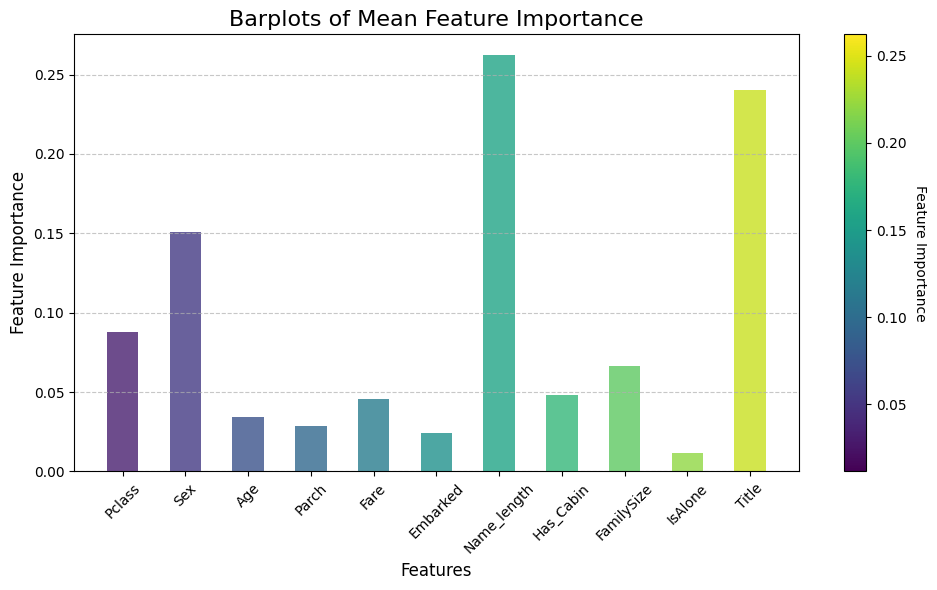

In [18]:
# 데이터 설정
x = feature_dataframe['features']
y = feature_dataframe['mean']

# 색상 설정 (Portland 스타일의 색상 그라데이션 적용)
colors = sns.color_palette("viridis", len(y))

# 그래프 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(x, y, color=colors, alpha=0.8, width=0.5)

# 색상 스케일 표시 (컬러바)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(y), vmax=max(y)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Feature Importance', rotation=270, labelpad=15)

# 그래프 스타일
plt.title('Barplots of Mean Feature Importance', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()


## Second-Level Predictions from the First-Level Output

### First-Level output as new features

In [19]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

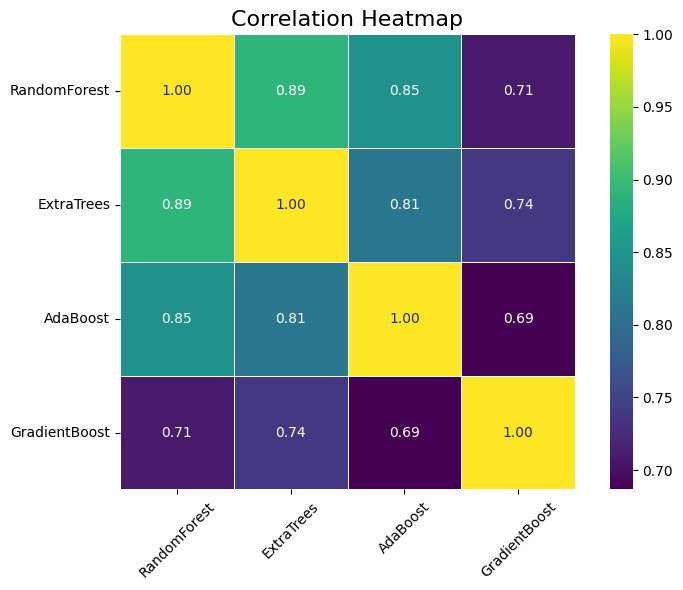

In [20]:
# 상관 행렬 계산
correlation_matrix = base_predictions_train.astype(float).corr()

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,           # 상관계수를 셀에 표시
    fmt=".2f",            # 소수점 두 자리까지 표시
    cmap="viridis",       # 색상 스케일 (Viridis)
    cbar=True,            # 컬러바 표시
    square=True,          # 셀이 정사각형이 되도록 설정
    linewidths=0.5        # 셀 간격
)

# 그래프 스타일
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# 그래프 출력
plt.show()


In [21]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [22]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [23]:
# Submission file
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)